In [51]:
#for qwen  82*10s (k=10)
# with using n= 10 batching = 354s
# 82*10/354  == 2.32 speedup

2.3163841807909606

In [53]:
# 354/10 -> 35.4s to generate one solution for all 981 puzzles

35.4

In [ ]:
kwargs={}
cfg_config

In [ ]:
# llama70 k=1 total time 
# llama70 k=10 total time 1412.5122587680817s
# llama70 k=20 total time 2419.7696826457977s
# llama70 k=40 total time 4482.509047746658s 

In [1]:
import numpy as np
list_time=np.array([452.7142667770386,1412.5122587680817, 2419.7696826457977, 4482.509047746658])
list_k=[1,10,20,40]

In [25]:
4482.509047746658/(60*60)

1.2451414021518494

In [23]:
452.7142667770386/112.06272619366646

4.0398291399288215

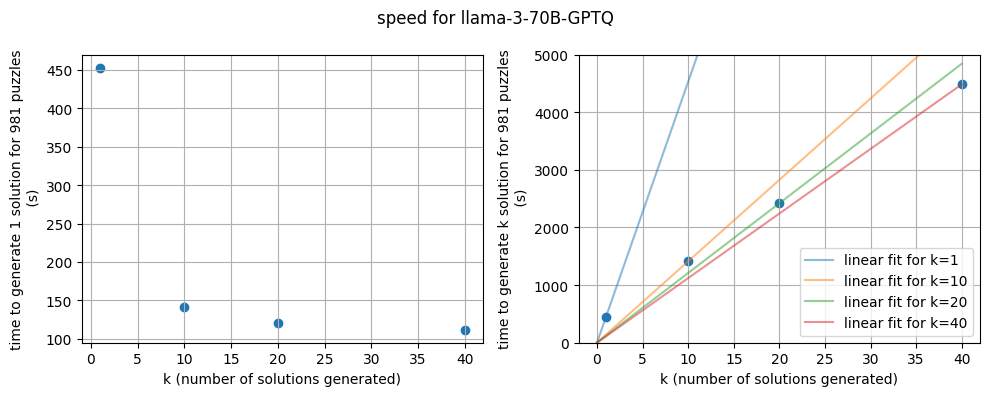

In [21]:
import matplotlib.pyplot as plt
f, axs = plt.subplots(1, 2, figsize=(10, 4))

# plt.figure(figsize=(10,5))
# plt.title("speed for llama-3-70B-GPTQ")
ax=axs[0]
ax.scatter(list_k, list_time/list_k)
ax.set_xlabel('k (number of solutions generated)')
ax.set_ylabel('time to generate 1 solution for 981 puzzles\n (s)')
ax.grid()

ax=axs[1]

ax.scatter(list_k, list_time)
ax.plot([0,40],[0,list_time[0]*40],label='linear fit for k=1',alpha=0.5)
ax.plot([0,40],[0,list_time[1]*4],label='linear fit for k=10',alpha=0.5)
ax.plot([0,40],[0,list_time[2]*2],label='linear fit for k=20',alpha=0.5)
ax.plot([0,40],[0,list_time[3]],label='linear fit for k=40',alpha=0.5)
ax.set_ylim(0,5000)
ax.set_xlabel('k (number of solutions generated)')
ax.set_ylabel('time to generate k solution for 981 puzzles\n (s)')
ax.grid()
ax.legend()
# plt.legend()
# plt.grid()
#set global title
plt.suptitle("speed for llama-3-70B-GPTQ")
f.tight_layout()


In [1]:
from openai import OpenAI
# python -m vllm.entrypoints.openai.api_server --model /home/flowers/work/hf/Llama-3-8B-Instruct-GPTQ-4-Bit --dtype auto --api-key token-abc123
model="/home/flowers/work/hf/CodeQwen1.5-7B-Chat-AWQ"#"/home/flowers/work/hf/Llama-3-8B-Instruct-GPTQ-4-Bit"#"/home/flowers/work/hf/deepseek-coder-6.7b-instruct"#"/home/flowers/work/hf/CodeQwen1.5-7B-Chat-AWQ"
client = OpenAI(
    base_url="http://localhost:8000/v1",
    api_key="token-abc123",
)
def generate_response(prompt,model=model,n=1):
    completion = client.chat.completions.create(
    model=model,
    max_tokens=1000,
    messages=[
        {"role": "user", "content": prompt}
    ],
    n=n
    )
    list_completion=[]
    if n>1:
        for i in range(len(completion.choices)):
            list_completion.append(completion.choices[i].message.content)
        if len(list_completion)!=n:
            print(f"Warning not enough completion: {len(list_completion)} completions instead of {n}")
        return list_completion
    return completion.choices[0].message.content
from concurrent.futures import ThreadPoolExecutor

def get_multiple_completions(batch_prompt: list[str], cfg_generation: dict=None,temperature=None,max_workers=10)->list[str]:
    """Get multiple completions from OpenAI API
    batch_tools =[[tools]] tools is the function, toll_name is the name of the tool

                    /!\ need to integrate batch tools in the loop /!\
    """
    # check that batch_prompt is list[str]
    if isinstance(batch_prompt, str):
        batch_prompt = [batch_prompt]
    completions = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        for idx,message_list in enumerate(batch_prompt):
            # kwargs_modified = args.copy()
            # kwargs_modified["messages"] = message_list
            # kwargs = {"client":client, "prompt":message_list}
            # kwargs["cfg_generation"]=cfg_generation
            # if temperature is not None:
            #     kwargs["temperature"]= temperature
            # if "kwargs" in kwargs_modified:
            #     original_kwargs = kwargs_modified.pop("kwargs")
            future = executor.submit(
                generate_response, message_list
            )
            completions.append(future)
    # Retrieve the results from the futures
    results = [future.result() for future in completions]
    return results

In [11]:
prompt="""Consider Python Programming Puzzles (P3). P3 consists of two functions: a problem function `f` and its corresponding solution `g`. The challenge lies in constructing a SAT problem `f` and a function `g` such that `f(g())` evaluates to `True`. Keep in mind that the person who needs to find the solution will be able to look at the the problem (function `f`)

## Main Rules:

- Each puzzle includes two functions: `def f(...)` and `def g(...)`.
- The first argument of `f` is always the output from `g()`.
- Ensure `f` and `g` have matching argument signatures (e.g., `def f(solution, arg1=value1, arg2=value2, ...)` and `def g(arg1=value1, arg2=value2, ...)`). You also need to set the value of argument of f (arg1,arg2,...) and g when you define them.
- Avoid using `f` inside `g`, and `g` inside `f`.
- Include any necessary imports so your code runs smoothly.
- Give a clear Puzzle description that must be brief and diverse compared to the other puzzles.
- Make sure the puzzle is self-contained within these two functions.

## P3 Format:

Puzzle Description: A two to four-sentence summary of the puzzle's content. To explain what is the problem `f`, and how you can solve it with `g`.

```python
def f(solution, args=...) -> bool:
    # Python code to test the solution returned by g.
    # This function is a test unit and must return True if the solution is correct and False otherwise.

def g(args=...) -> solution:
    # Python code to generate a solution for the problem.
    # The solution should generalize to all possible args.
    return solution

assert f(g()) == True

```

Now I have a list of 20 following skills. Can you, for each skill, give me 20 diverse keywords or short ideas to help me create very **hard** Programming Puzzles:
skill_list = [
"String Manipulation",
"Mathematical Operations",
"Conditional Logic",
"Recursion",
"Brute Force Search",
"Dynamic Programming",
"Greedy Algorithms",
"Backtracking",
"Set Operations",
"Permutations and Combinations",
"Probability and Statistics",
"Pattern Recognition",
"Sorting and Ordering",
"Binary Operations (bitwise shifting, AND, OR)",
"Geometry and Coordinate Manipulation",
"Algorithm Optimization",
"Number Theory (factors, primes, etc.)",
"Graph Theory (paths, edges, vertices)",
"Array Indexing",
"Hashing"
]
Let's think step by step to help me create very **hard** Programming Puzzles that are still solvable in a few minutes and with less than 30-40 lines of code."""



In [12]:
model="/gpfsscratch/rech/imi/uqv82bm/hf/Meta-Llama-3-70B-Instruct-GPTQ"
completion = client.chat.completions.create(
model=model,
max_tokens=5000,
n=32,
messages=[
    {"role": "user", "content": prompt}
],
temperature=1.
)

In [13]:
len(completion.choices[0].message.content)

2657

In [14]:
list_id=[]
for i in range(len(completion.choices)):
    if len(completion.choices[i].message.content)>9000:
        list_id.append(i)
        print(i)

14
15
17
18
19
20
21
23
24
25
26
27
28
29
30
31


In [15]:
#i=0
print(19)
print(completion.choices[i].message.content)


19
I'd be happy to help you with that. Here are 20 diverse keywords or short ideas for each of the 20 skills to create challenging Programming Puzzles:

**String Manipulation**

1. Anagram pair detection
2. Palindrome substrings
3. Caesar cipher decryption
4. Longest common substring
5. String compression using run-length encoding
6. Check for valid email formats
7. Minimum unique characters required
8. Phone number formatting
9. URL shortening
10. Validating credit card numbers
11. Palindromic permutations
12. String similarity measurement
13. HTML tag extraction
14. Find all permutations of a string
15. Regex pattern matching
16. Base64 encoding and decoding
17. Shortest unique prefix
18. Anagram sorting
19. Edit distance calculation
20. Find the longest word in a sentence

**Mathematical Operations**

1. Modular arithmetic
2. Fractional multiplication
3. Sqrt decomposition
4. Binary exponentiation
5. Prime number generation
6. Greatest common divisor
7. LCM calculation
8. Number of 

In [17]:
import json
path_save="test_2.json"
with open(path_save,"w") as f:
    out=[completion.choices[j].message.content for j in list_id]
    json.dump(out,f,indent=4)

In [29]:
import sys 
sys.path.append("/home/flowers/work/OpenELM")
from util_fn import base_elm_prompt_fn,P3ProbSolResult
import numpy as np
import json
#"/home/flowers/work/OpenELM/analysis_P3/heritability/selected_genomes_umap.json"#
path="/home/flowers/work/OpenELM/src/openelm/utils/preprocess_p3_emb_dedup_puzzles.json"#"/home/flowers/work/OpenELM/analysis_P3/generation/p3_pb_dataset.json"
with open(path, 'r') as f:
    data = json.load(f)

list_pb=[P3ProbSolResult(**i) for i in data]
for i in list_pb:
    import_typing="from typing import List"
    if "list" in i.program_str.lower() and "list" not in i.program_str.lower():
        i.program_str=import_typing +"\n" +i.program_str

In [46]:
data[0]

{'program_str': 'def f(n: int) -> bool:\n    return str(n * n).startswith(\'123456789\')\ndef g():\n    return int(int("123456789" + "0" * 9) ** 0.5) + 1\nassert f(g()) == True',
 'emb': [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'explanation_emb': 'The puzzle involves mathematical operations and string manipulation.',
 'description': "Find the solution: n (integer) that should be squared to produce a number whose string representation starts with '123456789'.",
 'quality': 1,
 'fitness': -0.30000000000000004,
 'all_solution': ['def f(n: int) -> bool:\n    return str(n * n).startswith(\'123456789\')\ndef g():\n    return int(int("123456789" + "0" * 9) ** 0.5) + 1\nassert f(g()) == True',
  "def f(n: int) -> bool:\n    return str(n * n).startswith('123456789')\ndef g():\n    import math\n    lower_bound = int(math.sqrt(123456789))\n    upper_bound = int(math.sqrt(198765432))\n    \n    for i in range(lower_bound, upper_bound + 1):\n        if str(i * i).startswith('1

In [3]:
# import sys 
# sys.path.append("/home/flowers/work/OpenELM")
# from util_fn import base_elm_prompt_fn,P3ProbSolResult
# from vllm import LLM,SamplingParams
# from transformers import AutoTokenizer
# import numpy as np

# # output_dir="/home/flowers/work/hf/deepseek-coder-6.7B-base-GPTQ"
# output_dir="/home/flowers/work/hf/CodeQwen1.5-7B-Chat"
# tokenizer=AutoTokenizer.from_pretrained(output_dir)

#             temperature=0.8,
#             top_p=1,
#             max_tokens=2000,
#             # presence_penalty=1.15,
#             # stop_token_ids=[tokenizer.eos_token_id, tokenizer.convert_tokens_to_ids("<|eot_id|>")]
            
#         )
# def create_conversation(instruction):
#     system_message = "You are a sentient, superintelligent artificial general intelligence, here to teach and assist me."#"""You are helpfull assistant."""
#     return [
#             {"role": "system", "content": system_message},
#             {"role": "user", "content": instruction},
#             ]
        

# def return_prompt_chat_str(list_promt):
#     out=create_conversation(list_promt)
#     out=tokenizer.apply_chat_template(out,tokenize=False,add_generation_prompt=True)
#     return out

# def get_prompt_str(list_prompt_2):
#     return list(map(return_prompt_chat_str,list_prompt_2))


# generation problem

In [30]:
prompt_rd_gen = """Consider Python Programming Puzzles (P3). P3 consists of two functions: a problem function `f` and its corresponding solution `g`. The challenge lies in constructing a SAT problem `f` and a function `g` such that `f(g())` evaluates to `True`

## Main Rules:
- Each puzzle includes two functions: `def f(...)` and `def g(...)`.
- The first argument of `f` is always the output from `g()`.
- Ensure `f` and `g` have matching argument signatures (e.g., `def f(arg0, arg1=value1, arg2=value2, ...)` and `def g(arg1=value1, arg2=value2, ...)`). You also need to set the value of argument of f (arg1,arg2,...) and g when you define them.
- Avoid using `f` inside `g`, and `g` inside `f`.
- Include any necessary imports so your code runs smoothly.
- Give a clear Puzzle description that must be brief and diverse compared to the other puzzles.
- Make sure the puzzle is self-contained within these two functions.

## P3 Format:
Puzzle description: A two to four sentence summary of the puzzle's content. To explain what is the problem `f`, and how you can solve it with `g`. 
```python
def f(solution, args=...) -> bool:
    # Python code to test the solution returned by g.
    # This function is a test unit and must return True if the solution is correct, and False otherwise.

def g(args=...) -> solution:
    # Python code to generate a solution for the problem.
    # The solution should generalize to all possible args.
    return solution

assert f(g()) == True
```

## Examples:
{examples}

Generate 5 different P3 similar to previous Examples.

## New 5 problems:
"""


In [31]:
prompt_elm= """Consider Python Programming Puzzles (P3). P3 consists of two functions: a problem function `f` and its corresponding solution `g`. The challenge lies in constructing a SAT problem `f` and a function `g` such that `f(g())` evaluates to `True`

## Main Rules:
- Each puzzle includes two functions: `def f(...)` and `def g(...)`.
- The first argument of `f` is always the output from `g()`.
- Ensure `f` and `g` have matching argument signatures (e.g., `def f(solution, arg1=value1, arg2=value2, ...)` and `def g(arg1=value1, arg2=value2, ...)`). You also need to set the value of argument of f (arg1,arg2,...) and g when you define them.
- Avoid using `f` inside `g`, and `g` inside `f`.
- Include any necessary imports so your code runs smoothly.
- Give a clear Puzzle description that must be brief and diverse compared to the other puzzles.
- Make sure the puzzle is self-contained within these two functions.

## P3 Format:
Puzzle description: A two to four sentence summary of the puzzle's content. To explain what is the problem `f`, and how you can solve it with `g`. 
```python
def f(solution, args=...) -> bool:
    # Python code to test the solution returned by g.
    # This function is a test unit and must return True if the solution is correct, and False otherwise.

def g(args=...) -> solution:
    # Python code to generate a solution for the problem.
    # The solution should generalize to all possible args.
    return solution

assert f(g()) == True
```

## Examples:
{examples}

Generate 5 P3 similar to the last Examples (Puzzle 2). Ensure that all new puzzles are more challenging than Puzzle 2.

## New 5 problems inspired by Puzzle 2:
"""
#Generate 5 different P3 similar to the last Examples (Puzzle 2). Ensure that all new puzzles are more challenging than Puzzle 2.


In [44]:
not (False or True)

False

In [ ]:
prompt_aces= """Consider Python Programming Puzzles (P3). P3 consists of two functions: a problem function `f` and its corresponding solution `g`. The challenge lies in constructing a SAT problem `f` and a function `g` such that `f(g())` evaluates to `True`

## Main Rules:
- Each puzzle includes two functions: `def f(...)` and `def g(...)`.
- The first argument of `f` is always the output from `g()`.
- Ensure `f` and `g` have matching argument signatures (e.g., `def f(solution, arg1=value1, arg2=value2, ...)` and `def g(arg1=value1, arg2=value2, ...)`). You also need to set the value of argument of f (arg1,arg2,...) and g when you define them.
- Avoid using `f` inside `g`, and `g` inside `f`.
- Include any necessary imports so your code runs smoothly.
- Give a clear Puzzle description that must be brief and diverse compared to the other puzzles.
- Make sure the puzzle is self-contained within these two functions.

## P3 Format:
Puzzle description: A two to four sentence summary of the puzzle's content. To explain what is the problem `f`, and how you can solve it with `g`. 
```python
def f(solution, args=...) -> bool:
    # Python code to test the solution returned by g.
    # This function is a test unit and must return True if the solution is correct, and False otherwise.

def g(args=...) -> solution:
    # Python code to generate a solution for the problem.
    # The solution should generalize to all possible args.
    return solution

assert f(g()) == True
```

## Examples:
{examples}

Generate 5 P3 similar to the last Examples (Puzzle 2). Ensure that all new puzzles are more challenging than Puzzle 2.

## New 5 problems inspired by Puzzle 2:
"""

## RD gen

In [32]:
list_prompt=[base_elm_prompt_fn(list_few_shot_example=np.random.choice(list_pb,size=3,replace=False),prompt=prompt_rd_gen) for _ in range(5)]


In [6]:
result= get_multiple_completions(list_prompt)

for i in range(len(result)):
    print("\n===================\n\n")
    print(list_prompt[i]+"\n"+result[i])




Consider Python Programming Puzzles (P3). P3 consists of two functions: a problem function `f` and its corresponding solution `g`. The challenge lies in constructing a SAT problem `f` and a function `g` such that `f(g())` evaluates to `True`

## Main Rules:
- Each puzzle includes two functions: `def f(...)` and `def g(...)`.
- The first argument of `f` is always the output from `g()`.
- Ensure `f` and `g` have matching argument signatures (e.g., `def f(arg0, arg1=value1, arg2=value2, ...)` and `def g(arg1=value1, arg2=value2, ...)`). You also need to set the value of argument of f (arg1,arg2,...) and g when you define them.
- Avoid using `f` inside `g`, and `g` inside `f`.
- Include any necessary imports so your code runs smoothly.
- Give a clear Puzzle description that must be brief and diverse compared to the other puzzles.
- Make sure the puzzle is self-contained within these two functions.

## P3 Format:
Puzzle description: A two to four sentence summary of the puzzle's content.

## ELM

In [15]:
list_prompt=[base_elm_prompt_fn(list_few_shot_example=np.random.choice(list_pb,size=2,replace=False),code_batch=np.random.choice(list_pb,size=1,replace=False),prompt=prompt_elm) for _ in range(10)]
# print(list_prompt[0])
from transformers import AutoTokenizer
tokenizer=AutoTokenizer.from_pretrained(model)

In [32]:
listprogramstr=[i.program_str for i in list_pb]
out = tokenizer(listprogramstr)

In [35]:
result= get_multiple_completions(list_prompt)

for i in range(len(result)):
    print("\n===================\n\n")
    print(list_prompt[i]+"\n"+result[i])




Consider Python Programming Puzzles (P3). P3 consists of two functions: a problem function `f` and its corresponding solution `g`. The challenge lies in constructing a SAT problem `f` and a function `g` such that `f(g())` evaluates to `True`

## Main Rules:
- Each puzzle includes two functions: `def f(...)` and `def g(...)`.
- The first argument of `f` is always the output from `g()`.
- Ensure `f` and `g` have matching argument signatures (e.g., `def f(solution, arg1=value1, arg2=value2, ...)` and `def g(arg1=value1, arg2=value2, ...)`). You also need to set the value of argument of f (arg1,arg2,...) and g when you define them.
- Avoid using `f` inside `g`, and `g` inside `f`.
- Include any necessary imports so your code runs smoothly.
- Give a clear Puzzle description that must be brief and diverse compared to the other puzzles.
- Make sure the puzzle is self-contained within these two functions.

## P3 Format:
Puzzle description: A two to four sentence summary of the puzzle's cont

In [26]:
4096+1024

5120

# test description

In [40]:
from pydantic import BaseModel,Field
from typing import List
from  util_fn import skill_list

format_skills=""
for idx,skill in enumerate(skill_list):
    format_skills+=f"{idx}. {skill}\n"
skills = f"\n{format_skills}"

# class Topics_evaluation(BaseModel):
#     """List of topics that are used in the problem and solution."""
#     explanations_index_topics: str = Field(decription="Short explanation of the specific topics employed in the puzzle.")
#     index_topics: List[int] = Field(description="list of at most 5 index correponding to topics that are actually used in the problem `f` or the solution `g`")
base_persona_code ="""You are a helpful assistant to a Professor teaching a programming course in Python. 
The Professor want to give Pyhton programming puzzles to his Computer Science student to teach them Python.
A Python programming puzzle is defined by two functions, the puzzle f(…) and the solution g(…). f defines an algorithmic challenge, and g solves this challenge. g is a solution to f if and only if f(g()) == True."""
prompt = base_persona_code+"\n"
prompt+= "The Professor want to evaluate the diversity of those puzzles, can you label the following puzzle given the following list of topics, please?"
# prompt = "Your role is: given the following puzzle, and the list of topics, exctract the information requested."
prompt += "\nThe list of topics is:\n"+ skills 
prompt += "\n\nThe puzzle is:\n```python\n" + "{puzzle}" + "\n```\n"
prompt += "Respond with two or three sentence explaning the topics used in the puzzle.\n"
prompt += "Then summarize your response by giving a list from 1 to 5 index corresponding to topics that are actually used in the puzzle above in this format: 'The list of skill use is: [].' where [] is the list of index of the topics used in the puzzle for example [3,5,6]."

In [41]:
print(prompt.format(puzzle=list_pb[0].program_str))

You are a helpful assistant to a Professor teaching a programming course in Python. 
The Professor want to give Pyhton programming puzzles to his Computer Science student to teach them Python.
A Python programming puzzle is defined by two functions, the puzzle f(…) and the solution g(…). f defines an algorithmic challenge, and g solves this challenge. g is a solution to f if and only if f(g()) == True.
The Professor want to evaluate the diversity of those puzzles, can you label the following puzzle given the following list of topics, please?
The list of topics is:

0. String Manipulation
1. Mathematical Operations
2. Conditional Logic
3. Recursion
4. Brute Force Search
5. Dynamic Programming
6. Greedy Algorithms
7. Backtracking
8. Set Operations
9. Permutations and Combinations
10. Probability and Statistics
11. Pattern Recognition
12. Sorting and Ordering
13. Binary Operations (bitwise shifting, AND, OR)
14. Geometry and Coordinate Manipulation
15. Algorithm Optimization
16. Number Th

In [42]:
from openai import OpenAI
client = OpenAI(
    base_url="http://localhost:8000/v1",
    api_key="token-abc123",
)
completion = client.chat.completions.create(
  model="/home/flowers/work/hf/CodeQwen1.5-7B-Chat",
  messages=[
    {"role": "user", "content": prompt.format(puzzle=list_pb[0].program_str)}
  ],
)

In [43]:
out=completion.choices[0].message.content
split_sentence="The list of skill use is:".lower()
if split_sentence in out.lower():
    try:
        out=out.split("use is:")[1]
    except:
        pass
try:
    out = out.split("[")[1].split("]")[0]
    out = "["+out+"]"
    out = json.loads(out)
except:
    skills=[]
    pass
isallint = all(isinstance(i, int) for i in skills)
if not isallint:
    skills = []

skill =[1 if i in skill else 0 for i in range(self.n_skills)]

In [26]:
json_template= {
    "type": "object",
    "properties": {
        "first_key": {
            "type": "array",
            "items": {"type": "string"},
            "minItems": 1
            },
        "another_key": {
            "type": "array",
            "items": {"type": "string"},
            "minItems": 1
            },
    "required": ["first_key", "another_key"]
    }
}
chat_response = client.chat.completions.create(
  model="/home/flowers/work/hf/CodeQwen1.5-7B-Chat",
    messages=[
        {"role": "user", "content": "Can you extract the following key in json: the first key is: ['absed'], the second key is: ['aaaccc']"},
    ],
    max_tokens=256,
    temperature=0.7,
    top_p=1,
    extra_body=dict(guided_json=json_template)
)


In [28]:
chat_response

ChatCompletion(id='cmpl-5a79da64cefb42e18496ad39aec1d853', choices=[Choice(finish_reason='length', index=0, logprobs=None, message=ChatCompletionMessage(content='To extract the key-value pairs from the given JSON data, you would need to have the JSON data before you can extract the keys. However, if you have the JSON data and know the keys you want to extract, you can use the json library in Python to do so. \n\nFor example, if you have the following JSON data:\n\n```json\n{\n    "absed": "value1",\n    "aaaccc": "value2"\n}\n```\n\nAnd you want to extract the values for the keys \'absed\' and \'aaaccc\', you can do so as follows:\n\n```python\nimport json\n\n# JSON data\njson_data = \'{"absed": "value1", "aaaccc": "value2"}\'\n\n# Parse JSON data\ndata = json.loads(json_data)\n\n# Extract values for the specified keys\nabsed_value = data[\'absed\']\naaaccc_value = data[\'aaaccc\']\n\nprint(f\'The value for key "absed" is: {absed_value}\')\nprint(f\'The value for key "aaaccc" is: {aaac